In [ ]:
!pip install torch transformers sentence-transformers accelerate bitsandbytes
!pip install chromadb langchain langchain_community langchain_huggingface langgraph
!pip install --upgrade langgraph

In [34]:
# ==============================================================================
# 0. Imports
# ==============================================================================
import torch
import json
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from typing import TypedDict, List, Optional
from functools import partial
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools.retriever import create_retriever_tool
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langgraph.graph import StateGraph, END
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langgraph.graph import StateGraph, END

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [36]:
# ==============================================================================
# 1. DEFINE THE AGENT STATE
# ==============================================================================
from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage # Import BaseMessage for typing

class AgentState(TypedDict):
    prompt: str
    data_sources: Optional[List[str]]
    tools: list
    plan: dict
    code: Optional[str]
    critique: Optional[str]
    documentation: Optional[str]
    revision_number: int
    messages: List[BaseMessage] # Add messages to store conversation history

In [48]:
# ==============================================================================
# 2. SETUP HUGGING FACE MODELS
# ==============================================================================

# Define the model ID
model_id = "distilbert/distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model without 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    #use_auth_token=None, # Replace with your HF token if using a gated model
)

# Create a Hugging Face pipeline
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=2048,
    repetition_penalty=1.1,
)
# Wrap the pipeline in the LangChain object
llm = HuggingFacePipeline(pipeline=hf_pipeline)

# --- Embedding Model for RAG ---
print("Loading Embedding Model: BAAI/bge-large-en-v1.5")
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

# --- Reranker Model for RAG Accuracy ---
print("Loading Reranker Model: BAAI/bge-reranker-large")
reranker_model = HuggingFaceCrossEncoder(
    model_name="BAAI/bge-reranker-large",
    model_kwargs={'device': device}
)
print("--- All models loaded successfully ---")

Device set to use cuda:0


Loading Embedding Model: BAAI/bge-large-en-v1.5
Loading Reranker Model: BAAI/bge-reranker-large
--- All models loaded successfully ---


In [41]:
# ==============================================================================
# 3. DEFINE THE GRAPH NODES
# ==============================================================================
# --- NODE 1: RAG Setup Node ---
def agent_node(state: AgentState, llm_with_tools):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

def tool_executor_node(state: AgentState, tool_executor):
    last_message = state["messages"][-1]
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        return
    tool_invocations = last_message.tool_calls
    tool_outputs = tool_executor.batch(tool_invocations)
    tool_messages = [ToolMessage(content=str(output), tool_call_id=inv["id"]) for inv, output in zip(tool_invocations, tool_outputs)]
    return {"messages": tool_messages}

def should_continue(state: AgentState):
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "call_tools"  # Route to the tool executor
    return "end_loop"

def planner_entry_node(state: AgentState):
    planner_prompt = f"""Based on the user's request, create a detailed, structured plan for writing the required code.
    Your final output must be a valid JSON object. Use your search tool if you need to find information about libraries or hardware.

    User Request: {state['messages'][0].content}
    """
    return {"messages": [HumanMessage(content=planner_prompt)]}

In [42]:
# ==============================================================================
# 3. DEFINE THE GRAPH NODES
# ==============================================================================
# --- NODE 1: RAG Setup Node ---

def rag_setup_node(state: AgentState):
    if not state.get("data_sources"):
        print("--- RAG SETUP: No data sources. Providing an empty tool list. ---")
        return {"tools": []}

    persist_directory = "./chroma_db"

    if os.path.exists(persist_directory):
        print(f"--- RAG SETUP: Loading existing Chroma DB from {persist_directory} ---")
        # Assuming embedding_model is defined globally or in a previous cell
        vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)
    else:
        print(f"--- RAG SETUP: Initializing RAG for sources: {state['data_sources']} ---")
        loader = WebBaseLoader(state["data_sources"])
        docs = loader.load()

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        splits = text_splitter.split_documents(docs)

        # Assuming embedding_model is defined globally or in a previous cell
        vectorstore = Chroma.from_documents(
            documents=splits,
            embedding=embedding_model, # <-- Use the HF model here
            persist_directory=persist_directory
        )
        vectorstore.persist() # Persist the database

    base_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

    # Assuming reranker_model is defined globally or in a previous cell
    compressor = CrossEncoderReranker(model=reranker_model, top_n=3)
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=base_retriever
    )

    rag_tool = create_retriever_tool(
        compression_retriever,
        "documentation_search",
        "Searches technical documentation for hardware specs, library usage, and pin configurations."
    )

    print("--- RAG SETUP: Advanced RAG tool with reranking is ready. ---")
    return {"tools": [rag_tool]}

# --- Generic Agent Prompt Template ---
agent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert agent. Your goal is to achieve the user's request by using your tools and providing a final, comprehensive answer."),
        MessagesPlaceholder(variable_name="chat_history"), # Use chat_history for memory
        ("human", "{input}"), # Use input for the current prompt
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# --- NODE 2: Planner Agent ---
def planner_agent_node(state: AgentState):
    print("--- PLANNER AGENT: Starting... ---")
    planner_prompt = f"""Based on the user's request, create a detailed, structured plan for writing the required code.
    Your final output must be a valid JSON object following this schema:
    {{
      "platform": "arduino or raspberry_pi",
      "board": "Specific board name (e.g., Arduino Uno, Raspberry Pi Pico)",
      "language": "e.g., C++, MicroPython",
      "components": ["List of hardware components"],
      "pins": {{"component_name": "pin_number"}},
      "logic_steps": ["Step-by-step logic"],
      "required_libraries": ["List of libraries"]
    }}

    User Request: {state['prompt']}
    """
    # Assuming llm and state["tools"] are defined globally or in previous cells
    # Bind tools to the LLM
    llm_with_tools = llm.bind_tools(state["tools"])
    agent = create_tool_calling_agent(llm_with_tools, state["tools"], agent_prompt)
    # Configure AgentExecutor with memory
    agent_executor = AgentExecutor(agent=agent, tools=state["tools"], verbose=True, memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True))
    result = agent_executor.invoke({"input": planner_prompt, "chat_history": state.get("messages", [])}) # Pass messages to memory

    try:
        plan = json.loads(result["output"])
    except json.JSONDecodeError:
        print("--- PLANNER AGENT: Warning: Failed to parse JSON, trying a fallback parser. ---")
        fallback_parser = JsonOutputParser()
        plan = fallback_parser.invoke(result["output"])


    print("--- PLANNER AGENT: Plan generated. ---")
    return {"plan": plan, "messages": state.get("messages", []) + [HumanMessage(content=planner_prompt), result["output"]]} # Update messages

# --- NODE 3: Code Generator Agent ---
def code_generator_agent_node(state: AgentState):
    print("--- CODE GENERATOR AGENT: Starting... ---")
    generator_prompt = f"""
    You are an expert programmer. Generate the complete, runnable code based on the plan.
    Only output the raw code inside a single code block (e.g., ```python ... ```). Do not add any other text or explanations.

    Plan:
    {json.dumps(state["plan"], indent=2)}

    {'Critique from previous attempt: ' + state['critique'] if state.get('critique') else ''}
    """
    # Assuming llm and state["tools"] are defined globally or in previous cells
    # Bind tools to the LLM
    llm_with_tools = llm.bind_tools(state["tools"])
    agent = create_tool_calling_agent(llm_with_tools, state["tools"], agent_prompt)
    # Configure AgentExecutor with memory
    agent_executor = AgentExecutor(agent=agent, tools=state["tools"], verbose=True, memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True))
    result = agent_executor.invoke({"input": generator_prompt, "chat_history": state.get("messages", [])}) # Pass messages to memory


    # Clean up the output to extract only the code
    code = StrOutputParser().invoke(result["output"]).strip().replace("```python", "").replace("```c++", "").replace("```", "")


    print("--- CODE GENERATOR AGENT: Code generated. ---")
    return {"code": code, "revision_number": state.get("revision_number", 0) + 1, "messages": state.get("messages", []) + [HumanMessage(content=generator_prompt), result["output"]]} # Update messages

# --- NODE 4: Validator Node ---
def validator_node(state: AgentState):
    print("--- VALIDATOR: Reviewing code... ---")
    validator_prompt = f"""You are a code reviewer. Review the code against the plan.
    If the code is correct and follows the plan, respond with the single word "OK".
    Otherwise, provide a concise, bulleted list of errors and suggestions for fixing them.

    Plan: {json.dumps(state['plan'])}
    Code:
    {state['code']}
    """
    # Assuming llm is defined globally or in a previous cell
    critique = llm.invoke(validator_prompt)

    print(f"--- VALIDATOR: Critique: {critique} ---")
    if "OK" in critique.upper():
        print("--- VALIDATOR: Code is good! ---")
        return {"critique": None, "messages": state.get("messages", []) + [HumanMessage(content=validator_prompt), AIMessage(content="OK")]} # Update messages with OK
    else:
        return {"critique": critique, "messages": state.get("messages", []) + [HumanMessage(content=validator_prompt), AIMessage(content=critique)]} # Update messages with critique

# --- NODE 5: Documentation Generator ---
def documentation_generator_node(state: AgentState):
    print("--- DOCUMENTATION GENERATOR: Creating documentation... ---")
    doc_prompt = f"""Generate a README.md for this project. Include sections for:
    1. Project Overview
    2. Hardware Requirements & Wiring
    3. Software Setup
    4. Code Explanation

    Original Request: {state['prompt']}
    Plan: {json.dumps(state['plan'])}
    Final Code:
    {state['code']}
    """
    # Assuming llm is defined globally or in a previous cell
    documentation = llm.invoke(doc_prompt)
    print("--- DOCUMENTATION GENERATOR: Complete ---")
    return {"documentation": documentation, "messages": state.get("messages", []) + [HumanMessage(content=doc_prompt), AIMessage(content=documentation)]} # Update messages

In [43]:
# ==============================================================================
# 4. CONSTRUCT THE GRAPH
# ==============================================================================

print("--- Constructing Agent Graph ---")
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("rag_setup", rag_setup_node)
workflow.add_node("planner_agent", planner_agent_node)
workflow.add_node("code_generator_agent", code_generator_agent_node)
workflow.add_node("validator", validator_node)
workflow.add_node("documentation_generator", documentation_generator_node)

# Define edges
workflow.set_entry_point("rag_setup")
workflow.add_edge("rag_setup", "planner_agent")
workflow.add_edge("planner_agent", "code_generator_agent")
workflow.add_edge("code_generator_agent", "validator")
workflow.add_edge("documentation_generator", END)

# Define conditional logic for the validation loop
def should_continue(state: AgentState):
    if state["critique"] is None:
        return "generate_docs"
    if state["revision_number"] > 3:
        print("--- MAX REVISIONS REACHED ---")
        return "generate_docs"
    else:
        return "continue_refining"

workflow.add_conditional_edges(
    "validator",
    should_continue,
    {
        "continue_refining": "code_generator_agent",
        "generate_docs": "documentation_generator",
    },
)

# Compile the graph
app = workflow.compile()
print("--- Graph Compiled Successfully ---")

--- Constructing Agent Graph ---
--- Graph Compiled Successfully ---


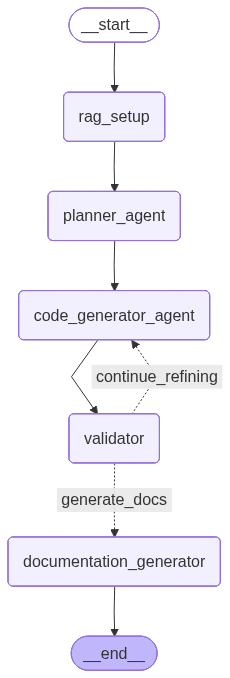

In [44]:
app

In [45]:
# ==============================================================================
# 5. EXECUTE THE AGENT
# ==============================================================================
print("\n--- Starting Agent Execution ---")

# Define the problem for the agent
inputs = {
    "prompt": "Write MicroPython code for a Raspberry Pi Pico to read temperature and humidity from a DHT22 sensor connected to GPIO pin 15. The readings should be printed to the console every 5 seconds.",
    "data_sources": ["https://www.tomshardware.com/how-to/raspberry-pi-pico-dht11-dht22-sensor"] # Corrected URL format
}

final_state = None
# Stream the output to see the step-by-step process
for output in app.stream(inputs, {"recursion_limit": 10}):
    for key, value in output.items():
        print(f"\n## Output from node: '{key}' ##")
        # You can print the full value for debugging if needed
        # print(value)
    final_state = list(output.values())[0] # Capture the latest state

print("\n\n--- Agent Execution Complete ---")

# Print the final results
if final_state:
    print("\n\n--- FINAL GENERATED CODE ---")
    print("```python")
    print(final_state.get("code", "Code not generated."))
    print("```")

    print("\n\n--- FINAL GENERATED DOCUMENTATION ---")
    print(final_state.get("documentation", "Documentation not generated."))


--- Starting Agent Execution ---
--- RAG SETUP: Loading existing Chroma DB from ./chroma_db ---
--- RAG SETUP: Advanced RAG tool with reranking is ready. ---

## Output from node: 'rag_setup' ##
--- PLANNER AGENT: Starting... ---


/tmp/ipython-input-2023168555.py:16: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)


AttributeError: 'HuggingFacePipeline' object has no attribute 'bind_tools'

In [49]:
# ==============================================================================
# 0. Installation (if not already installed)
# ==============================================================================
# !pip install torch transformers sentence-transformers accelerate bitsandbytes
# !pip install chromadb langchain langchain_community langchain_huggingface langgraph
# !pip install --upgrade langgraph
# !pip install pypdf reportlab # Added for PDF processing and creation

# ==============================================================================
# 1. Imports
# ==============================================================================
import torch
import json
import os
import getpass
import re
from typing import TypedDict, List, Optional

# LangChain and LangGraph components
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools.retriever import create_retriever_tool
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# Transformers for Hugging Face models
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig


# ==============================================================================
# 3. DEFINE THE AGENT STATE
# ==============================================================================
class AgentState(TypedDict):
    prompt: str
    data_sources: Optional[List[str]]
    plan: dict
    code: Optional[str]
    critique: Optional[str]
    documentation: Optional[str]
    revision_number: int
    messages: List[BaseMessage]

# ==============================================================================
# 4. SETUP HUGGING FACE MODELS
# ==============================================================================

# --- Main Language Model (LLM) ---
# We are using a more powerful, instruction-tuned model capable of complex reasoning.

# Configuration for 4-bit quantization to save memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ.get("HF_TOKEN"))
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config,
    token=os.environ.get("HF_TOKEN")
)

# Create a Hugging Face pipeline
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=4096, # Increased token limit for code generation
    repetition_penalty=1.1,
    return_full_text=False, # Important for chat-like interactions
)
# Wrap the pipeline in the LangChain object
llm = HuggingFacePipeline(pipeline=hf_pipeline)


# --- Embedding Model for RAG ---
print("Loading Embedding Model: BAAI/bge-large-en-v1.5")
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True}
)

# --- Reranker Model for RAG Accuracy ---
print("Loading Reranker Model: BAAI/bge-reranker-large")
reranker_model = HuggingFaceCrossEncoder(
    model_name="BAAI/bge-reranker-large",
    model_kwargs={'device': device}
)
print("--- All models loaded successfully ---")


# ==============================================================================
# 5. DEFINE TOOLS
# ==============================================================================

# --- RAG Tool Setup ---
def create_rag_tool(data_sources: List[str]):
    """Dynamically creates a RAG tool from a list of web or PDF sources."""
    if not data_sources:
        print("--- RAG: No data sources provided. Skipping tool creation. ---")
        return []

    docs = []
    for source in data_sources:
        if source and source.lower().startswith("http"):
            print(f"--- RAG: Loading web page: {source} ---")
            loader = WebBaseLoader([source])
            docs.extend(loader.load())
        elif source and source.lower().endswith(".pdf"):
            print(f"--- RAG: Loading PDF: {source} ---")
            if os.path.exists(source):
                loader = PyPDFLoader(source)
                docs.extend(loader.load())
            else:
                print(f"--- RAG WARNING: PDF file not found at {source} ---")
        elif source:
            print(f"--- RAG WARNING: Unrecognized source type: {source} ---")

    if not docs:
        print("--- RAG: No documents were successfully loaded. Skipping tool creation. ---")
        return []

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)
    base_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
    compressor = CrossEncoderReranker(model=reranker_model, top_n=3)
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=base_retriever
    )

    rag_tool = create_retriever_tool(
        compression_retriever,
        "documentation_search",
        "Searches technical documentation for hardware specs, library usage, and code examples."
    )
    print("--- RAG: Advanced RAG tool with reranking is ready. ---")
    return [rag_tool]

# ==============================================================================
# 6. DEFINE THE GRAPH NODES
# ==============================================================================

# --- NODE 1: Planner ---
# This node creates a detailed plan for the code generation by acting as a true agent.
def planner_node(state: AgentState):
    print("--- PLANNER: Creating a plan... ---")
    tools = create_rag_tool(state.get("data_sources", []))

    llm_with_tools = llm.bind_tools(tools)

    # Prompt template for the planner agent, instructing it to use tools
    planner_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert planner. Your task is to create a detailed, structured plan for writing the code requested by the user.
        You MUST use your search tool (`documentation_search`) if you need more information about specific libraries, hardware pins, or APIs. Do not guess or hallucinate details.
        After using your tools (or if you determine they are not needed), your final response must be ONLY the valid JSON object containing the plan. Do not add any other text or explanations around the JSON.
        The JSON object must follow this schema:
        {{
            "platform": "e.g., arduino, raspberry_pi",
            "board": "Specific board name (e.g., Arduino Uno, Raspberry Pi Pico)",
            "language": "e.g., C++, MicroPython",
            "components": ["List of hardware components"],
            "pins": {{"component_name": "pin_number_or_connection"}},
            "logic_steps": ["Step-by-step logic for the code"],
            "required_libraries": ["List of necessary libraries"]
        }}"""),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    # Create the tool-calling agent and executor
    agent = create_tool_calling_agent(llm_with_tools, tools, planner_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # Invoke the agent to get the plan
    result = agent_executor.invoke({"input": state["prompt"]})
    output_str = result["output"]

    # Robustly parse the JSON output from the agent
    try:
        plan = json.loads(output_str)
    except json.JSONDecodeError:
        print("--- PLANNER ERROR: Failed to parse JSON. Attempting to extract from markdown. ---")
        match = re.search(r"```json\n(.*)\n```", output_str, re.DOTALL)
        if match:
            plan = json.loads(match.group(1))
        else:
            raise ValueError("Planner agent did not return a valid JSON plan.")

    print("--- PLANNER: Plan generated. ---")
    messages = [
        HumanMessage(content=state["prompt"]),
        AIMessage(content=f"Understood. Here is the plan to generate the code:\n\n```json\n{json.dumps(plan, indent=2)}\n```")
    ]
    return {"plan": plan, "messages": messages}


# --- NODE 2: Code Generator ---
def code_generator_node(state: AgentState):
    print("--- CODER: Generating code... ---")
    generator_prompt = f"""You are an expert programmer. Generate the complete, runnable code based on the provided plan.
    Only output the raw code inside a single code block (e.g., ```python ... ```). Do not add any other text or explanations.

    Plan:
    {json.dumps(state["plan"], indent=2)}

    {'Critique from previous attempt: ' + state['critique'] if state.get('critique') else ''}
    """
    result = llm.invoke(generator_prompt)

    # More robustly extract code from a markdown block
    match = re.search(r"```(?:\w+\n)?(.*)```", result, re.DOTALL)
    if match:
        code = match.group(1).strip()
    else:
        code = result.strip() # Fallback if no markdown block is found

    print("--- CODER: Code generated. ---")
    messages = state["messages"] + [AIMessage(content=f"Here is the generated code:\n\n```{state['plan'].get('language', '')}\n{code}\n```")]
    return {
        "code": code,
        "revision_number": state.get("revision_number", 0) + 1,
        "messages": messages
    }

# --- NODE 3: Validator / Code Critiquer ---
def validator_node(state: AgentState):
    print("--- VALIDATOR: Reviewing code... ---")
    validator_prompt = f"""You are a senior code reviewer. Your task is to review the generated code against the original plan.
    If the code is correct, complete, and perfectly follows the plan, respond with the single word "OK".
    Otherwise, provide a concise, bulleted list of errors, missing parts, or suggestions for fixing the code. Be specific and constructive.

    Plan: {json.dumps(state['plan'])}
    Code:
    ```{state['plan'].get('language', '')}
    {state['code']}
    ```
    """
    critique = llm.invoke(validator_prompt)

    if "OK" in critique.upper():
        print("--- VALIDATOR: Code is good! ---")
        messages = state["messages"] + [AIMessage(content="The code has been validated and looks correct.")]
        return {"critique": None, "messages": messages}
    else:
        print(f"--- VALIDATOR: Found issues. Critique: {critique} ---")
        messages = state["messages"] + [AIMessage(content=f"The code has some issues. Here is the critique:\n\n{critique}")]
        return {"critique": critique, "messages": messages}

# --- NODE 4: Documentation Generator ---
def documentation_generator_node(state: AgentState):
    print("--- DOCUMENTER: Creating documentation... ---")
    doc_prompt = f"""You are a technical writer. Generate a comprehensive README.md for this project.
    Include the following sections:
    1.  **Project Overview**: A brief description of what the project does.
    2.  **Hardware Requirements**: A list of all components from the plan.
    3.  **Wiring Diagram**: A clear description of how to connect the components.
    4.  **Software Setup**: Instructions on how to set up the environment and install libraries.
    5.  **Code Explanation**: A step-by-step breakdown of how the code works.

    Original Request: {state['prompt']}
    Plan: {json.dumps(state['plan'])}
    Final Code:
    ```{state['plan'].get('language', '')}
    {state['code']}
    ```
    """
    documentation = llm.invoke(doc_prompt)
    print("--- DOCUMENTER: Complete. ---")
    messages = state["messages"] + [AIMessage(content=f"Finally, here is the documentation for the project:\n\n{documentation}")]
    return {"documentation": documentation, "messages": messages}

# ==============================================================================
# 7. CONSTRUCT THE GRAPH
# ==============================================================================

print("--- Constructing Agent Graph ---")
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("code_generator", code_generator_node)
workflow.add_node("validator", validator_node)
workflow.add_node("documentation_generator", documentation_generator_node)

workflow.set_entry_point("planner")
workflow.add_edge("planner", "code_generator")
workflow.add_edge("code_generator", "validator")
workflow.add_edge("documentation_generator", END)

def validation_router(state: AgentState):
    """Determines the next step after validation."""
    if state.get("critique") is None:
        print("--- ROUTER: Validation successful. Proceeding to documentation. ---")
        return "generate_docs"
    if state.get("revision_number", 0) > 3:
        print("--- ROUTER: Max revisions reached. Proceeding to documentation. ---")
        return "generate_docs"
    else:
        print("--- ROUTER: Validation failed. Returning to code generator. ---")
        return "refine_code"

workflow.add_conditional_edges(
    "validator",
    validation_router,
    {"refine_code": "code_generator", "generate_docs": "documentation_generator"},
)

app = workflow.compile()
print("--- Graph Compiled Successfully ---")

# ==============================================================================
# 8. EXECUTE THE AGENT
# ==============================================================================
print("\n--- Starting Agent Execution ---")

try:
    from reportlab.pdfgen import canvas
    from reportlab.lib.pagesizes import letter
    pdf_path = "dht22_pico_guide.pdf"
    c = canvas.Canvas(pdf_path, pagesize=letter)
    c.drawString(72, 800, "Raspberry Pi Pico and DHT22 Guide")
    c.drawString(72, 780, "The DHT22 sensor is a popular choice for measuring temperature and humidity.")
    c.drawString(72, 760, "To use it with a Raspberry Pi Pico, you need the 'dht' library.")
    c.drawString(72, 740, "Connect the VCC pin to 3.3V, GND to GND, and the Data pin to a GPIO pin, like GP15.")
    c.save()
    print(f"--- Created dummy PDF for testing: {pdf_path} ---")
except ImportError:
    print("--- reportlab not found, skipping dummy PDF creation. `pip install reportlab` to enable. ---")
    pdf_path = None

inputs = {
    "prompt": "Write MicroPython code for a Raspberry Pi Pico to read temperature and humidity from a DHT22 sensor connected to GPIO pin 15. The readings should be printed to the console every 5 seconds.",
    "data_sources": [
        "https://www.tomshardware.com/how-to/raspberry-pi-pico-dht11-dht22-sensor",
        pdf_path
    ]
}

final_state = {}
for output in app.stream(inputs, {"recursion_limit": 15}):
    for key, value in output.items():
        print(f"\n## Output from node: '{key}' ##")
        final_state.update(value)

print("\n\n--- Agent Execution Complete ---")

if final_state:
    print("\n\n--- FINAL GENERATED CODE ---")
    print(f"```{final_state.get('plan', {}).get('language', '')}")
    print(final_state.get("code", "Code not generated."))
    print("```")

    print("\n\n--- FINAL GENERATED DOCUMENTATION ---")
    print(final_state.get("documentation", "Documentation not generated."))

    print("\n\n--- FULL CONVERSATION LOG ---")
    for msg in final_state.get("messages", []):
        print(f"[{msg.type.upper()}]:")
        content = msg.content
        # Pretty print JSON content if it's a string that looks like JSON
        if isinstance(content, str) and content.strip().startswith('{'):
            try:
                parsed_json = json.loads(content)
                print(json.dumps(parsed_json, indent=2))
            except json.JSONDecodeError:
                print(content)
        else:
            print(content)
        print("-" * 20)



Device set to use cuda:0


Loading Embedding Model: BAAI/bge-large-en-v1.5
Loading Reranker Model: BAAI/bge-reranker-large
--- All models loaded successfully ---
--- Constructing Agent Graph ---
--- Graph Compiled Successfully ---

--- Starting Agent Execution ---
--- reportlab not found, skipping dummy PDF creation. `pip install reportlab` to enable. ---
--- PLANNER: Creating a plan... ---
--- RAG: Loading web page: https://www.tomshardware.com/how-to/raspberry-pi-pico-dht11-dht22-sensor ---
--- RAG: Advanced RAG tool with reranking is ready. ---


AttributeError: 'HuggingFacePipeline' object has no attribute 'bind_tools'

In [54]:
!pip install langchain-tavily
from langchain_community.tools.tavily_search import TavilySearchResults

In [56]:
from langchain_tavily import TavilySearch

In [58]:
# ==============================================================================
# 0. Installation (if not already installed)
# ==============================================================================
# !pip install torch transformers sentence-transformers accelerate bitsandbytes
# !pip install chromadb langchain langchain_community langchain_huggingface langgraph
# !pip install --upgrade langgraph
# !pip install tavily # Added for Tavily search tool

# ==============================================================================
# 1. Imports
# ==============================================================================
import torch
import json
import os
import getpass
import re
from typing import TypedDict, List, Optional

# LangChain and LangGraph components
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# Transformers for Hugging Face models
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Check if GPU is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ==============================================================================
# 2. Securely Set API Keys
# ==============================================================================
# NOTE: HF_TOKEN is not required for distilgpt2, but good practice for gated models.
# if "HF_TOKEN" not in os.environ:
#     try:
#         os.environ["HF_TOKEN"] = getpass.getpass("Enter your Hugging Face token: ")
#     except Exception as e:
#         print(f"Could not read Hugging Face token: {e}")

# Securely set Tavily API key, which is required for the search tool
if "TAVILY_API_KEY" not in os.environ:
    try:
        os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")
    except Exception as e:
        print(f"Could not read Tavily API key: {e}")
        # The agent will fail without this key.
        exit()


# ==============================================================================
# 3. DEFINE THE AGENT STATE
# ==============================================================================
class AgentState(TypedDict):
    prompt: str
    plan: dict
    code: Optional[str]
    critique: Optional[str]
    documentation: Optional[str]
    revision_number: int
    messages: List[BaseMessage]

# ==============================================================================
# 4. SETUP HUGGING FACE MODELS
# ==============================================================================

# --- Main Language Model (LLM) ---
# CRITICAL NOTE: The model has been changed to 'distilbert/distilgpt2' as requested.
# This model is a very small, non-instruction-tuned model. It does NOT have the
# capability to perform the complex tasks required by this agent, such as:
#   - Following instructions to generate structured JSON.
#   - Reasoning about when to use tools like Tavily Search.
#   - Generating coherent code from a plan.
# As a result, while the code is now syntactically correct, THE AGENT WILL NOT
# FUNCTION AS INTENDED. For this agent to work, a powerful, instruction-tuned
# model like 'meta-llama/Meta-Llama-3-8B-Instruct' is required.
model_id = "distilbert/distilgpt2"
print(f"Loading Main LLM: {model_id}")


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Create a Hugging Face pipeline
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024, # Reduced for smaller model
    repetition_penalty=1.1,
    return_full_text=False, # Important for chat-like interactions
)
# Wrap the pipeline in the LangChain object
llm = HuggingFacePipeline(pipeline=hf_pipeline)

print("--- LLM loaded successfully ---")

Using device: cuda
Loading Main LLM: distilbert/distilgpt2


Device set to use cuda:0


--- LLM loaded successfully ---


In [59]:
# ==============================================================================
# 5. DEFINE THE GRAPH NODES
# ==============================================================================

# --- NODE 1: Planner ---
# This node creates a detailed plan for the code generation by acting as a true agent.
def planner_node(state: AgentState):
    print("--- PLANNER: Creating a plan... ---")
    # Initialize the Tavily search tool
    tools = [TavilySearchResults(max_results=3)]

    # Prompt template for the planner agent, instructing it to use the search tool
    planner_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert planner. Your task is to create a detailed, structured plan for writing the code requested by the user.
        You MUST use your search tool to find information about specific libraries, hardware pins, or APIs if you are unsure. Do not guess or hallucinate details.
        After using your tools (or if you determine they are not needed), your final response must be ONLY the valid JSON object containing the plan. Do not add any other text or explanations around the JSON.
        The JSON object must follow this schema:
        {{
            "platform": "e.g., arduino, raspberry_pi",
            "board": "Specific board name (e.g., Arduino Uno, Raspberry Pi Pico)",
            "language": "e.g., C++, MicroPython",
            "components": ["List of hardware components"],
            "pins": {{"component_name": "pin_number_or_connection"}},
            "logic_steps": ["Step-by-step logic for the code"],
            "required_libraries": ["List of necessary libraries"]
        }}"""),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    # Create the tool-calling agent and executor
    agent = create_tool_calling_agent(llm, tools, planner_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # Invoke the agent to get the plan
    result = agent_executor.invoke({"input": state["prompt"]})
    output_str = result["output"]

    # Robustly parse the JSON output from the agent
    try:
        plan = json.loads(output_str)
    except json.JSONDecodeError:
        print("--- PLANNER ERROR: Failed to parse JSON. Attempting to extract from markdown. ---")
        match = re.search(r"```json\n(.*)\n```", output_str, re.DOTALL)
        if match:
            plan = json.loads(match.group(1))
        else:
            # This error is expected with distilgpt2 as it cannot reliably produce JSON.
            raise ValueError("Planner agent did not return a valid JSON plan.")

    print("--- PLANNER: Plan generated. ---")
    messages = [
        HumanMessage(content=state["prompt"]),
        AIMessage(content=f"Understood. Here is the plan to generate the code:\n\n```json\n{json.dumps(plan, indent=2)}\n```")
    ]
    return {"plan": plan, "messages": messages}


# --- NODE 2: Code Generator ---
def code_generator_node(state: AgentState):
    print("--- CODER: Generating code... ---")
    generator_prompt = f"""You are an expert programmer. Generate the complete, runnable code based on the provided plan.
    Only output the raw code inside a single code block (e.g., ```python ... ```). Do not add any other text or explanations.

    Plan:
    {json.dumps(state["plan"], indent=2)}

    {'Critique from previous attempt: ' + state['critique'] if state.get('critique') else ''}
    """
    result = llm.invoke(generator_prompt)

    # More robustly extract code from a markdown block
    match = re.search(r"```(?:\w+\n)?(.*)```", result, re.DOTALL)
    if match:
        code = match.group(1).strip()
    else:
        code = result.strip() # Fallback if no markdown block is found

    print("--- CODER: Code generated. ---")
    messages = state["messages"] + [AIMessage(content=f"Here is the generated code:\n\n```{state['plan'].get('language', '')}\n{code}\n```")]
    return {
        "code": code,
        "revision_number": state.get("revision_number", 0) + 1,
        "messages": messages
    }

# --- NODE 3: Validator / Code Critiquer ---
def validator_node(state: AgentState):
    print("--- VALIDATOR: Reviewing code... ---")
    validator_prompt = f"""You are a senior code reviewer. Your task is to review the generated code against the original plan.
    If the code is correct, complete, and perfectly follows the plan, respond with the single word "OK".
    Otherwise, provide a concise, bulleted list of errors, missing parts, or suggestions for fixing the code. Be specific and constructive.

    Plan: {json.dumps(state['plan'])}
    Code:
    ```{state['plan'].get('language', '')}
    {state['code']}
    ```
    """
    critique = llm.invoke(validator_prompt)

    if "OK" in critique.upper():
        print("--- VALIDATOR: Code is good! ---")
        messages = state["messages"] + [AIMessage(content="The code has been validated and looks correct.")]
        return {"critique": None, "messages": messages}
    else:
        print(f"--- VALIDATOR: Found issues. Critique: {critique} ---")
        messages = state["messages"] + [AIMessage(content=f"The code has some issues. Here is the critique:\n\n{critique}")]
        return {"critique": critique, "messages": messages}

# --- NODE 4: Documentation Generator ---
def documentation_generator_node(state: AgentState):
    print("--- DOCUMENTER: Creating documentation... ---")
    doc_prompt = f"""You are a technical writer. Generate a comprehensive README.md for this project.
    Include the following sections:
    1.  **Project Overview**: A brief description of what the project does.
    2.  **Hardware Requirements**: A list of all components from the plan.
    3.  **Wiring Diagram**: A clear description of how to connect the components.
    4.  **Software Setup**: Instructions on how to set up the environment and install libraries.
    5.  **Code Explanation**: A step-by-step breakdown of how the code works.

    Original Request: {state['prompt']}
    Plan: {json.dumps(state['plan'])}
    Final Code:
    ```{state['plan'].get('language', '')}
    {state['code']}
    ```
    """
    documentation = llm.invoke(doc_prompt)
    print("--- DOCUMENTER: Complete. ---")
    messages = state["messages"] + [AIMessage(content=f"Finally, here is the documentation for the project:\n\n{documentation}")]
    return {"documentation": documentation, "messages": messages}

# ==============================================================================
# 6. CONSTRUCT THE GRAPH
# ==============================================================================

print("--- Constructing Agent Graph ---")
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("code_generator", code_generator_node)
workflow.add_node("validator", validator_node)
workflow.add_node("documentation_generator", documentation_generator_node)

workflow.set_entry_point("planner")
workflow.add_edge("planner", "code_generator")
workflow.add_edge("code_generator", "validator")
workflow.add_edge("documentation_generator", END)

def validation_router(state: AgentState):
    """Determines the next step after validation."""
    if state.get("critique") is None:
        print("--- ROUTER: Validation successful. Proceeding to documentation. ---")
        return "generate_docs"
    if state.get("revision_number", 0) > 3:
        print("--- ROUTER: Max revisions reached. Proceeding to documentation. ---")
        return "generate_docs"
    else:
        print("--- ROUTER: Validation failed. Returning to code generator. ---")
        return "refine_code"

workflow.add_conditional_edges(
    "validator",
    validation_router,
    {"refine_code": "code_generator", "generate_docs": "documentation_generator"},
)

app = workflow.compile()
print("--- Graph Compiled Successfully ---")

# ==============================================================================
# 7. EXECUTE THE AGENT
# ==============================================================================
print("\n--- Starting Agent Execution ---")

# The 'data_sources' key is no longer needed as we are using Tavily for general search.
inputs = {
    "prompt": "Write MicroPython code for a Raspberry Pi Pico to read temperature and humidity from a DHT22 sensor connected to GPIO pin 15. The readings should be printed to the console every 5 seconds.",
}

final_state = {}
try:
    for output in app.stream(inputs, {"recursion_limit": 15}):
        for key, value in output.items():
            print(f"\n## Output from node: '{key}' ##")
            final_state.update(value)
except ValueError as e:
    print(f"\n--- AGENT FAILED ---")
    print(f"An error occurred, likely due to the limitations of the 'distilbert/distilgpt2' model.")
    print(f"Error details: {e}")


print("\n\n--- Agent Execution Complete ---")

if final_state and "code" in final_state:
    print("\n\n--- FINAL GENERATED CODE ---")
    print(f"```{final_state.get('plan', {}).get('language', '')}")
    print(final_state.get("code", "Code not generated."))
    print("```")

    print("\n\n--- FINAL GENERATED DOCUMENTATION ---")
    print(final_state.get("documentation", "Documentation not generated."))

    print("\n\n--- FULL CONVERSATION LOG ---")
    for msg in final_state.get("messages", []):
        print(f"[{msg.type.upper()}]:")
        content = msg.content
        # Pretty print JSON content if it's a string that looks like JSON
        if isinstance(content, str) and content.strip().startswith('{'):
            try:
                parsed_json = json.loads(content)
                print(json.dumps(parsed_json, indent=2))
            except json.JSONDecodeError:
                print(content)
        else:
            print(content)
        print("-" * 20)
else:
    print("\n--- No final output was generated. The agent likely failed in an early step. ---")



--- Constructing Agent Graph ---
--- Graph Compiled Successfully ---

--- Starting Agent Execution ---
--- PLANNER: Creating a plan... ---

--- AGENT FAILED ---
An error occurred, likely due to the limitations of the 'distilbert/distilgpt2' model.
Error details: This function requires a bind_tools() method be implemented on the LLM.


--- Agent Execution Complete ---

--- No final output was generated. The agent likely failed in an early step. ---
